In [1]:
%load_ext autoreload
%autoreload 2

Trying out regression with L2 loss

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data as D
import torch.optim as optim

from custom_datasets import TreeDataset, TreeClassDataset
from show_data import imshow

In [12]:
print(torch.cuda.is_available())
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


False


In [15]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class ColorNet(nn.Module):
    def __init__(self):
        super(ColorNet, self).__init__()
        self.features = nn.Sequential(
            # conv1
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=64),
            
            # conv2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=128),
            
            # conv3
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size = 3, stride = 2, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features = 256),
            
            # conv4
            nn.Conv2d(256, 512, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features = 512),
            
            # conv5
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1, padding = 2, dilation = 2),
            nn.ReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1, padding = 2, dilation = 2),
            nn.ReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 2, padding = 2, dilation = 2),
            nn.ReLU(),
            nn.BatchNorm2d(num_features = 512),
            
            # fc6
            nn.MaxPool2d(2,2),
            Flatten(),
            nn.Linear(25088, 4096),
            nn.ReLU(),
            nn.Linear(4096, 6272),   
        )
        self.features.to(dev)
    def forward(self, x):
        features = self.features(x)
        return features

net = ColorNet()
net.to(dev)

ColorNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (15): ReLU()
    (16): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (17): Conv2d(256, 512, kernel_size=(3, 

In [10]:
# to present as image
#img_tensor = torch.zeros([3,224,224])
#img_tensor[0] = inputs[0]
#img_tensor[1] = label[0][0]
#img_tensor[2] = label[0][1]
#imshow(img_tensor)

In [39]:
def imshow_wrapper(inputs, label):
    img_tensor = torch.zeros([3,224,224])
    img_tensor[0] = inputs[0]
    img_tensor[1] = label[0][0]
    img_tensor[2] = label[0][1]
    imshow(img_tensor)

In [5]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

torch.Size([8, 2, 56, 56])
torch.Size([8, 2, 224, 224])


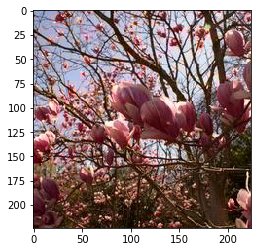

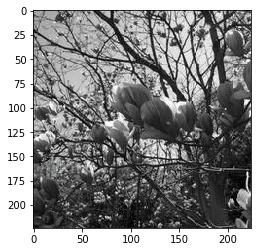

torch.Size([8, 2, 56, 56])
torch.Size([8, 2, 224, 224])


/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 48 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


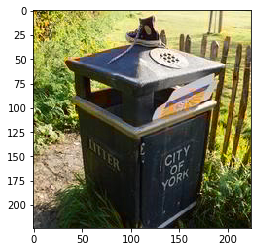

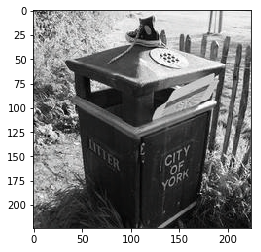

In [54]:
batch_size = 8
tree_d = TreeDataset()
loader = D.DataLoader(tree_d, batch_size=batch_size, shuffle=True)

# training
for epoch in range(2):
    running_loss = 0.0
    iterations = len(tree_d) // batch_size
    #print('epoch', epoch)
    #print('iterations:', iterations)
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        inputs.to(dev)
        labels.to(dev)
        
        print(labels.size())
        
        inputs = inputs.float()
        
        optimizer.zero_grad()
        
        # reshape labels
        labels = labels.view(labels.size(0), -1)
        labels = labels.float()
        
        outputs = net(inputs)
        
        #print('output size', outputs.size())
        
        
        # reshape again for presentation
        labels = labels.view(labels.size(0), 2, 56, -1)
        labels = F.interpolate(labels, scale_factor=4)
        
        outputs = outputs.view(outputs.size(0), 2, 56, -1)
        outputs = F.interpolate(outputs, scale_factor=4)
        
        print(outputs.size())
        imshow_wrapper(inputs, labels)
        imshow_wrapper(inputs, outputs.detach())
        
        
        break
        
        # print(outputs.size())
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        print(i, loss.item())
        break

torch.save(net.state_dict(), './models/net-1')

In [21]:
class ColorNet(nn.Module):
    def __init__(self):
        super(ColorNet, self).__init__()
        self.features = nn.Sequential(
            # conv1
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=64),
            
            # conv2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=128),
            
            # conv3
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size = 3, stride = 2, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features = 256),
            
            # conv4
            nn.Conv2d(256, 512, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features = 512),
            
            # conv5
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1, padding = 2, dilation = 2),
            nn.ReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1, padding = 2, dilation = 2),
            nn.ReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1, padding = 2, dilation = 2),
            nn.ReLU(),
            nn.BatchNorm2d(num_features = 512),
            
            # fc6
        )
    def forward(self, x):
        features = self.features(x)
        return features

net = ColorNet()